<a href="https://colab.research.google.com/github/Kwangbin/finance/blob/main/1_%EA%B3%A0%EC%86%8C%EB%93%9D_%EA%B3%A0%EA%B0%9D_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8%EB%A7%81_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 패키지 설치 : optbinning, restart runtime
# 특정 변수에서 최적의 IV를 찾아 주는 tool
!pip install optbinning

     |████████████████████████████████| 195 kB 36.9 MB/s 
     |████████████████████████████████| 28.5 MB 50 kB/s 
     |████████████████████████████████| 178 kB 38.8 MB/s 
     |████████████████████████████████| 14.4 MB 98 kB/s 
  Created wheel for pympler: filename=Pympler-0.9-py3-none-any.whl size=164824 sha256=76bd9a82e36f55438e51803a2691c7a49d173bf6d5df196b587d8b4d4a836c6c
  Stored in directory: /root/.cache/pip/wheels/1a/f3/d8/35d5614ea4ddd295ffb9372a5f2f9570d9593d1ea4be33ec6d
  Created wheel for accumulation-tree: filename=accumulation_tree-0.6.2-cp37-cp37m-linux_x86_64.whl size=234397 sha256=a58d92864ef168fbdf3be0a9d3178bdcc6b9faf68a60aaccfc743b1f2dbdda76
  Stored in directory: /root/.cache/pip/wheels/42/32/0e/08020ae396bf92a3fd00971d0b81a6fb8f3e0681fd8912760d
  Created wheel for pyudorandom: filename=pyudorandom-1.0.0-py3-none-any.whl size=2221 sha256=7ce595874534b20d978ffe5b6971e2eacff5dd9c145064947723de80d5715b3f
  Stored in directory: /root/.cache/pip/wheels/9b/d0/30/b2916c

In [3]:
!pip install shap

     |████████████████████████████████| 356 kB 29.2 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491645 sha256=98bdb386a015706fab6a8b76304a8435d72a6ff42cf7eb76dabc9369e088bacb
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir(r"/content/drive/MyDrive/ml/kait/finance/dataset")
import common as cm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#javascript 불러오기
import shap


shap.initjs()

#data 가져오기
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [6]:
labels

array([0, 0, 0, ..., 0, 0, 1])

In [7]:
len(data["Age"].unique())

73

강의 자료 출처 

https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608

In [8]:
#numerical data 기초 통계랑
data.describe()

,Age,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581646,10.080679,1077.649170,87.303833,40.437454
std,13.640442,2.572562,7385.911621,403.014771,12.347933
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [9]:
#결측치 확인 : 결측 없음
data.isnull().sum(axis = 0) /len(data)

Age               0.0
Workclass         0.0
Education-Num     0.0
Marital Status    0.0
Occupation        0.0
Relationship      0.0
Race              0.0
Sex               0.0
Capital Gain      0.0
Capital Loss      0.0
Hours per week    0.0
Country           0.0
dtype: float64

In [10]:
# 범주형과 연속형 변수 구분
cate_cols =     []
cont_cols =     []
not_sure_cols = []

for col in data.columns:
    size_of_state_space = len(data[col].unique()) # 상태공간 크기 정의
    col_type = data[col].dtype # 컬럼의 데이터 타입 확인
    print(col, col_type, size_of_state_space)
    if size_of_state_space > 10 and col_type in [int, float, 'int64', 'int32', 'int8','float32', 'float64', 'float16']: # 상태공간의 크기가 10 초과이고, 데이터 타입이 int나 float
        cont_cols.append(col)
    elif size_of_state_space < 10 and col_type in [object]: # 상태공간의 크기가 10 미만이고, 데이터타입이 object
        cate_cols.append(col)   
    elif col_type in ['category']: # 데이터타입이 category
        cate_cols.append(col)        
    else: # 위의 두 조건을 만족못하면 더 확인해보기!
        not_sure_cols.append(col)    
print(cont_cols)        
print(cate_cols)        
print(not_sure_cols) 

Age float32 73
Workclass category 9
Education-Num float32 16
Marital Status category 7
Occupation category 15
Relationship category 6
Race category 5
Sex category 2
Capital Gain float32 119
Capital Loss float32 92
Hours per week float32 94
Country category 42
['Age', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
[]


In [11]:
# Split Train , Test Data Set 
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(data, labels, random_state=42, stratify=labels)

In [13]:
#Binning 해보기 : 연속형 변수 Age
from optbinning import OptimalBinning

col = "Age"
bin_x = Train_X[col]

#OptimalBinning
# https://www.wenyanet.com/opensource/ko/604480310e886502ad3086a0.html
optb = OptimalBinning(name=col, dtype="numerical", solver="cp")
optb.fit(bin_x, Train_Y)

binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 19.50)",1241,0.050819,1239,2,0.001612,5.28076,0.351129,0.022212
1,"[19.50, 22.50)",1681,0.068837,1669,12,0.007139,3.78692,0.333196,0.027013
2,"[22.50, 25.50)",1866,0.076413,1795,71,0.038049,2.08193,0.176444,0.018775
3,"[25.50, 27.50)",1243,0.050901,1126,117,0.094127,1.1161,0.045584,0.005420
4,"[27.50, 29.50)",1264,0.051761,1074,190,0.150316,0.583971,0.014964,0.001844
5,"[29.50, 31.50)",1338,0.054791,1064,274,0.204783,0.208513,0.002252,0.000281
6,"[31.50, 33.50)",1283,0.052539,993,290,0.226033,0.0826999,0.000352,0.000044
7,"[33.50, 36.50)",1950,0.079853,1428,522,0.267692,-0.141787,0.001664,0.000208
8,"[36.50, 38.50)",1279,0.052375,857,422,0.329945,-0.439717,0.011226,0.001392
9,"[38.50, 43.50)",3000,0.122850,1964,1036,0.345333,-0.508534,0.035710,0.004416


In [23]:
bin_x

19359          Adm-clerical
15003                 Sales
12490     Handlers-cleaners
32292      Transport-moving
5163                  Sales
                ...        
31450        Prof-specialty
20560       Protective-serv
23650       Exec-managerial
25301       Exec-managerial
5800          Other-service
Name: Occupation, Length: 24420, dtype: category
Categories (15, object): [' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ...,
                          ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving']

In [14]:
optb.transform(bin_x, metric="woe")

array([ 0.5839714 , -0.14178725,  2.08193062, ..., -0.51933086,
        1.11610307,  5.2807629 ])

In [16]:
optb.status

'OPTIMAL'

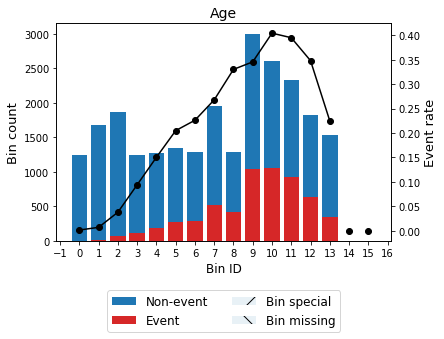

In [17]:
binning_table.plot(metric="event_rate")

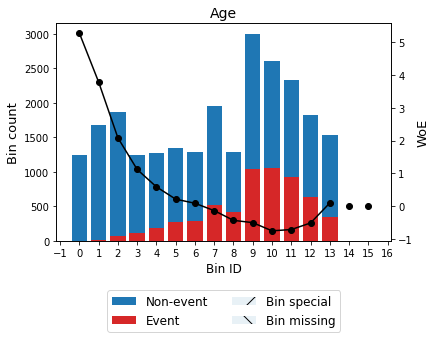

In [18]:
binning_table.plot(metric="woe")

In [24]:
#monotonic_trend -> 우상향 또는 우하향만 허용 : auto_asc_desc

col = "Age"
bin_x = Train_X[col]

optb_mono = OptimalBinning(name=col, dtype="numerical", solver="cp", monotonic_trend ="auto_asc_desc")
optb_mono.fit(bin_x, Train_Y)

binning_table_mono = optb_mono.binning_table
binning_table_mono.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 19.50)",1241,0.050819,1239,2,0.001612,5.28076,0.351129,0.022212
1,"[19.50, 22.50)",1681,0.068837,1669,12,0.007139,3.78692,0.333196,0.027013
2,"[22.50, 25.50)",1866,0.076413,1795,71,0.038049,2.08193,0.176444,0.018775
3,"[25.50, 27.50)",1243,0.050901,1126,117,0.094127,1.1161,0.045584,0.005420
4,"[27.50, 29.50)",1264,0.051761,1074,190,0.150316,0.583971,0.014964,0.001844
5,"[29.50, 31.50)",1338,0.054791,1064,274,0.204783,0.208513,0.002252,0.000281
6,"[31.50, 33.50)",1283,0.052539,993,290,0.226033,0.0826999,0.000352,0.000044
7,"[33.50, 36.50)",1950,0.079853,1428,522,0.267692,-0.141787,0.001664,0.000208
8,"[36.50, 38.50)",1279,0.052375,857,422,0.329945,-0.439717,0.011226,0.001392
9,"[38.50, 43.50)",3000,0.122850,1964,1036,0.345333,-0.508534,0.035710,0.004416


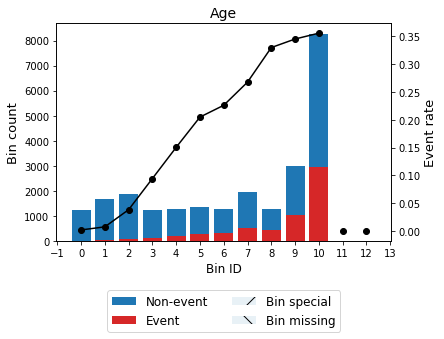

In [25]:
binning_table_mono.plot(metric="event_rate")

In [26]:
#Binning 해보기 : 범주형 변수 Occupation

col = "Occupation"
bin_x = Train_X[col]

optb = OptimalBinning(name=col, dtype="categorical", solver="mip", cat_cutoff=0.1)
optb.fit(bin_x, Train_Y)

binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[ Other-service],2450,0.100328,2340,110,0.044898,1.90928,0.205278,0.022358
1,[ Adm-clerical],2781,0.113882,2426,355,0.127652,0.773731,0.054545,0.006653
2,[ Craft-repair],3081,0.126167,2386,695,0.225576,0.085312,0.000898,0.000112
3,[ Sales],2750,0.112613,2028,722,0.262545,-0.11537,0.001543,0.000193
4,[ Prof-specialty],3123,0.127887,1713,1410,0.451489,-0.953493,0.140502,0.016926
5,[ Exec-managerial],3064,0.125471,1575,1489,0.485966,-1.092,0.183709,0.021887
6,"[ Machine-op-inspct, ?, Transport-moving, H...",7171,0.293653,6071,1100,0.153396,0.560063,0.078649,0.009705
7,Special,0,0.000000,0,0,0.000000,0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0,0.000000,0.000000
Totals,,24420,1.000000,18539,5881,0.240827,,0.665124,0.077834


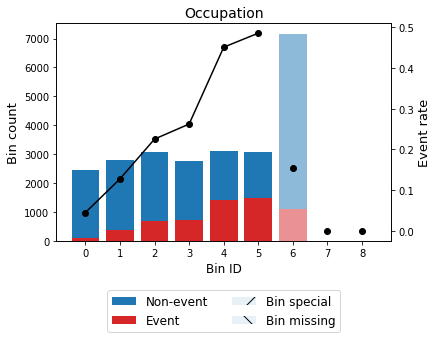

In [27]:
binning_table.plot(metric="event_rate")

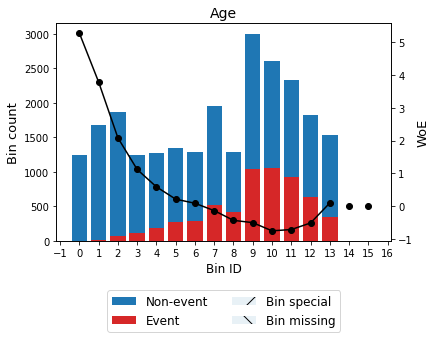

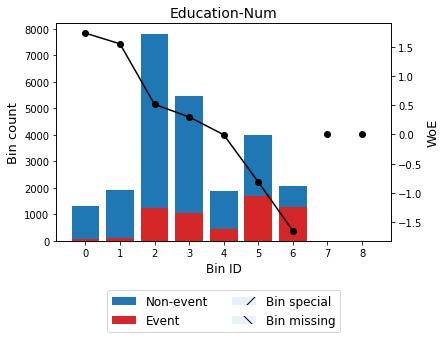

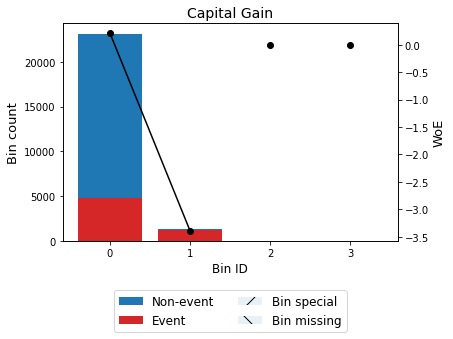

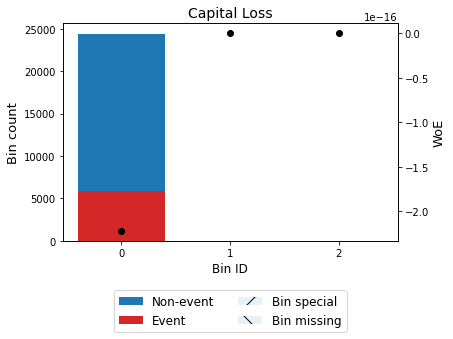

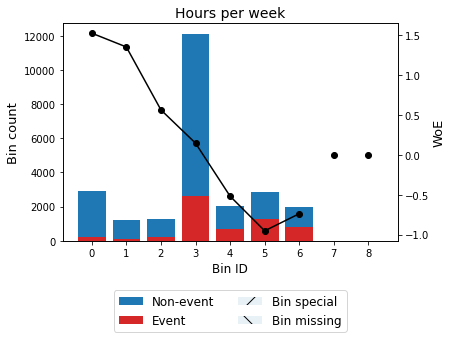

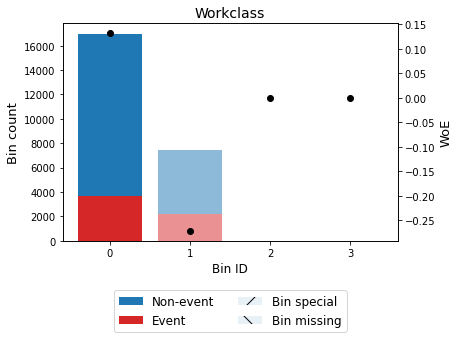

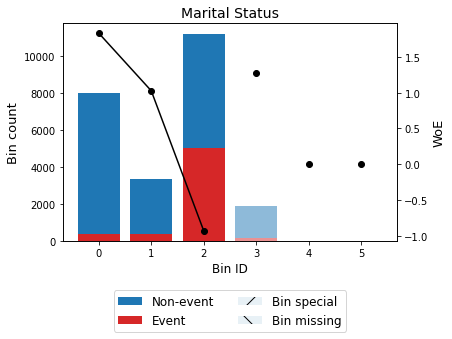

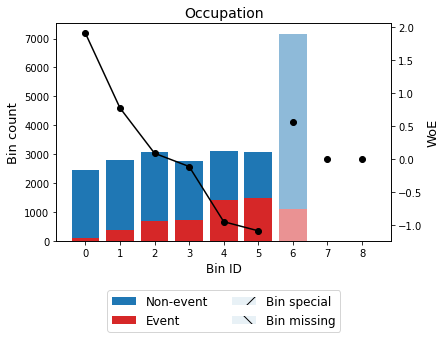

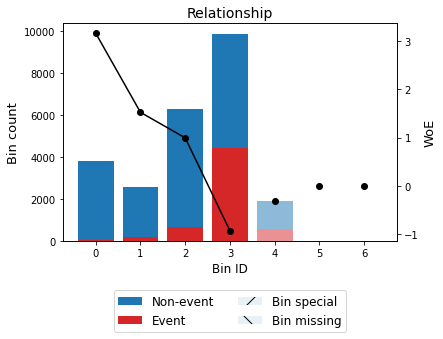

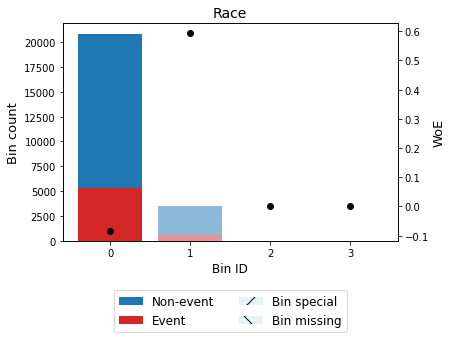

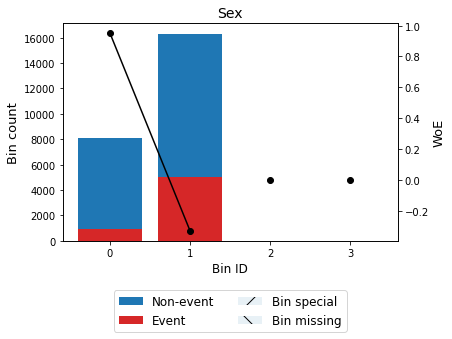

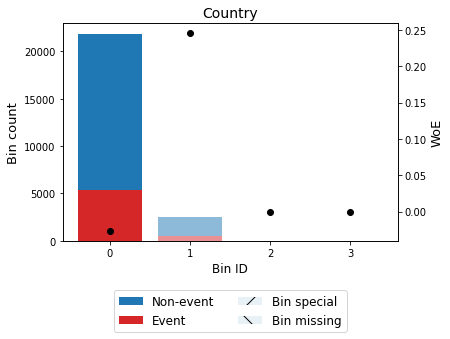

In [28]:
# 전체 변수 binning
Train_X_B = pd.DataFrame(index=Train_X.index)
Test_X_B  = pd.DataFrame(index=Test_X.index)
Df_IV     = pd.DataFrame(columns=["column_name", "IV", "status"])

from optbinning import OptimalBinning

i_cnt = 0
for col in cont_cols:
  
  bin_x = Train_X[col].values
  test_x = Test_X[col].values

  optb = OptimalBinning(name=col, dtype="numerical", solver="cp")
  optb.fit(bin_x, Train_Y)

  x_transform_woe = optb.transform(bin_x, metric="woe")
  Train_X_B[col] = x_transform_woe

  x_transform_woe = optb.transform(test_x, metric="woe")
  Test_X_B[col] = x_transform_woe

  binning_table = optb.binning_table
  binning_table.build()

  binning_table.plot(metric="woe")

  #OPTIMAL 상태만 사용
  if optb.status == 'OPTIMAL' :
    Df_IV.loc[i_cnt] = (col, binning_table.iv, optb.status)
    i_cnt += 1

for col in cate_cols:
  bin_x = Train_X[col].values
  test_x = Test_X[col].values

  optb = OptimalBinning(name=col, dtype="categorical", solver="mip", cat_cutoff=0.1)
  optb.fit(bin_x, Train_Y)

  x_transform_woe = optb.transform(bin_x, metric="woe")
  Train_X_B[col] = x_transform_woe

  x_transform_woe = optb.transform(test_x, metric="woe")
  Test_X_B[col] = x_transform_woe

  binning_table = optb.binning_table
  binning_table.build()

  binning_table.plot(metric="woe")

  #OPTIMAL 상태만 사용
  if optb.status == 'OPTIMAL' :
    Df_IV.loc[i_cnt] = (col, binning_table.iv, optb.status)
    i_cnt += 1

In [29]:
Train_X_B

,Age,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Marital Status,Occupation,Relationship,Race,Sex,Country
19359,0.583971,0.297920,0.209352,-2.220446e-16,0.144423,0.131656,1.832574,0.773731,0.993076,-0.083491,0.951172,-0.026604
15003,-0.141787,-0.006947,0.209352,-2.220446e-16,-0.739332,0.131656,-0.932916,-0.115370,-0.940158,-0.083491,-0.329975,-0.026604
12490,2.081931,0.297920,0.209352,-2.220446e-16,0.144423,0.131656,1.832574,0.560063,-0.322880,-0.083491,-0.329975,0.245514
32292,-0.508534,0.297920,0.209352,-2.220446e-16,-0.520108,0.131656,-0.932916,0.560063,-0.940158,-0.083491,-0.329975,-0.026604
5163,1.116103,-1.649902,0.209352,-2.220446e-16,0.144423,0.131656,1.832574,-0.115370,3.171203,-0.083491,-0.329975,-0.026604
...,...,...,...,...,...,...,...,...,...,...,...,...
31450,-0.519331,-1.649902,0.209352,-2.220446e-16,0.144423,0.131656,-0.932916,-0.953493,-0.940158,-0.083491,-0.329975,-0.026604
20560,-0.508534,0.297920,0.209352,-2.220446e-16,1.349092,0.131656,1.026070,0.560063,1.524752,0.593543,0.951172,-0.026604
23650,-0.519331,0.512365,0.209352,-2.220446e-16,-0.953812,0.131656,-0.932916,-1.091999,-0.940158,0.593543,-0.329975,-0.026604
25301,1.116103,-0.815275,0.209352,-2.220446e-16,-0.953812,0.131656,-0.932916,-1.091999,-0.940158,-0.083491,-0.329975,-0.026604


In [30]:
Train_X

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19359,28.0,Private,10.0,Never-married,Adm-clerical,Not-in-family,White,Female,0.0,0.0,40.0,United-States
15003,35.0,Private,12.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,60.0,United-States
12490,24.0,Private,10.0,Never-married,Handlers-cleaners,Other-relative,White,Male,0.0,0.0,40.0,Italy
32292,41.0,Private,10.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,48.0,United-States
5163,27.0,Private,14.0,Never-married,Sales,Own-child,White,Male,0.0,0.0,40.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
31450,55.0,Private,14.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States
20560,39.0,Private,10.0,Divorced,Protective-serv,Unmarried,Black,Female,0.0,0.0,30.0,United-States
23650,55.0,Private,9.0,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0.0,0.0,55.0,United-States
25301,26.0,Private,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,55.0,United-States


In [31]:
Df_IV.sort_values(by=['IV'], axis=0, ascending=False)

,column_name,IV,status
8,Relationship,1.399741,OPTIMAL
6,Marital Status,1.305481,OPTIMAL
0,Age,1.125569,OPTIMAL
1,Education-Num,0.723874,OPTIMAL
2,Capital Gain,0.675990,OPTIMAL
7,Occupation,0.665124,OPTIMAL
4,Hours per week,0.467998,OPTIMAL
10,Sex,0.305952,OPTIMAL
9,Race,0.049352,OPTIMAL
5,Workclass,0.035653,OPTIMAL


In [32]:
#Logistic Regression 모델링

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42).fit(Train_X_B, Train_Y)
print(clf.score(Test_X_B, Test_Y))

df_ks = pd.DataFrame(Test_Y, columns=["y"])
df_ks["p"] = clf.predict_proba(Test_X_B)[:,1]
my_df = cm.ks(data=df_ks, target="y", prob="p")

0.8491585800270237
        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.736731  0.996679     709        105     36.17%         1.70%   
2       0.468995  0.736184     461        351     23.52%         5.68%   
3       0.331496  0.468594     343        472     17.50%         7.64%   
4       0.214738  0.331409     219        595     11.17%         9.63%   
5       0.111797  0.214598     123        692      6.28%        11.20%   
6       0.053635  0.111790      64        750      3.27%        12.13%   
7       0.027291  0.053584      29        785      1.48%        12.70%   
8       0.010961  0.027280       6        807      0.31%        13.06%   
9       0.001866  0.010947       6        809      0.31%        13.09%   
10      0.000046  0.001863       0        815      0.00%        13.19%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       


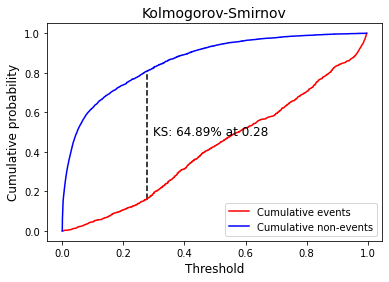

In [33]:
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
predictions = clf.predict_proba(Test_X_B)[:,1]
plot_ks(Test_Y, predictions)

In [34]:
predictions = clf.predict(Test_X_B)
predictions[:10]
class_labels = list(set(labels))
cm.display_model_performance_metrics(true_labels=Test_Y, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8492
Precision: 0.8419
Recall: 0.8492
F1 Score: 0.8419

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6181
           1       0.74      0.57      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.75      0.77      8141
weighted avg       0.84      0.85      0.84      8141


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       5796   385
        1        843  1117


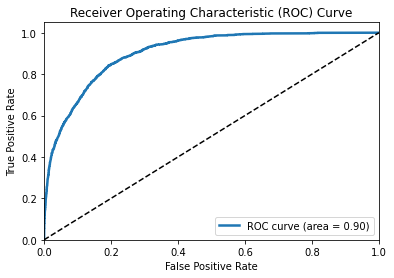

In [35]:
cm.plot_model_roc_curve(clf, Test_X_B,true_labels=Test_Y )

In [36]:
clf_pred_pr = clf.predict_proba(Test_X_B)[:,1]

In [37]:
threshold = 0.3
pred2 = (clf_pred_pr>= threshold)

from sklearn.metrics import confusion_matrix, plot_precision_recall_curve


cm.display_model_performance_metrics(true_labels=Test_Y, 
                                      predicted_labels=pred2, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8227
Precision: 0.851
Recall: 0.8227
F1 Score: 0.8308

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      6181
           1       0.60      0.81      0.69      1960

    accuracy                           0.82      8141
   macro avg       0.76      0.82      0.78      8141
weighted avg       0.85      0.82      0.83      8141


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       5115  1066
        1        377  1583


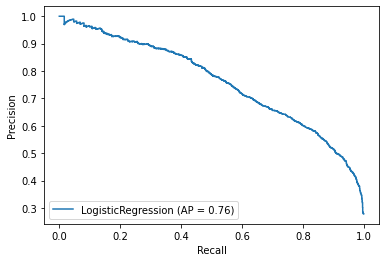

In [38]:
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve

plot_precision_recall_curve(clf,Test_X_B, Test_Y)

In [39]:
print(clf.coef_, clf.intercept_)

#y = -1.23 + -0.6*X_B[1] + ...


[[-6.33756115e-01 -7.89354974e-01 -9.45419547e-01  2.46285897e-16
  -5.03291124e-01  2.38552447e-01 -7.39969613e-01 -4.40507321e-01
  -2.31959525e-01 -2.24791397e-01 -2.91312408e-02 -7.95148257e-01]] [-1.23766941]


In [40]:
Test_X_B

,Age,Education-Num,Capital Gain,Capital Loss,...,Relationship,Race,Sex,Country
17581,-0.720374,0.297920,0.209352,-2.220446e-16,...,0.993076,0.593543,0.951172,-0.026604
16280,1.116103,0.512365,0.209352,-2.220446e-16,...,3.171203,-0.083491,-0.329975,-0.026604
24719,0.082700,0.297920,0.209352,-2.220446e-16,...,-0.940158,-0.083491,-0.329975,-0.026604
3986,0.208513,0.512365,0.209352,-2.220446e-16,...,0.993076,-0.083491,0.951172,-0.026604
5138,-0.508534,0.297920,0.209352,-2.220446e-16,...,3.171203,-0.083491,-0.329975,-0.026604
...,...,...,...,...,...,...,...,...,...
6837,2.081931,1.548263,0.209352,-2.220446e-16,...,0.993076,-0.083491,-0.329975,-0.026604
7133,3.786923,1.730246,0.209352,-2.220446e-16,...,1.524752,-0.083491,-0.329975,-0.026604
25363,2.081931,0.297920,0.209352,-2.220446e-16,...,-0.322880,-0.083491,-0.329975,-0.026604
13085,-0.759298,0.512365,0.209352,-2.220446e-16,...,-0.940158,-0.083491,-0.329975,-0.026604


In [41]:
#상위 5개 변수만 선택
Df_IV = Df_IV.sort_values(by=['IV'], axis=0, ascending=False)
Df_IV = Df_IV.reset_index(drop=True)
fin_col  = []
for i, row in Df_IV.iterrows():
  fin_col.append(row["column_name"])
  if i>3 : break

Df_IV, fin_col

(       column_name        IV   status
 0     Relationship  1.399741  OPTIMAL
 1   Marital Status  1.305481  OPTIMAL
 2              Age  1.125569  OPTIMAL
 3    Education-Num  0.723874  OPTIMAL
 4     Capital Gain  0.675990  OPTIMAL
 5       Occupation  0.665124  OPTIMAL
 6   Hours per week  0.467998  OPTIMAL
 7              Sex  0.305952  OPTIMAL
 8             Race  0.049352  OPTIMAL
 9        Workclass  0.035653  OPTIMAL
 10         Country  0.006528  OPTIMAL
 11    Capital Loss  0.000000  OPTIMAL,
 ['Relationship', 'Marital Status', 'Age', 'Education-Num', 'Capital Gain'])

In [42]:
from sklearn.linear_model import LogisticRegression
clf_fin = LogisticRegression(random_state=42).fit(Train_X_B[fin_col], Train_Y)
print(clf_fin.score(Test_X_B[fin_col], Test_Y))

df_ks = pd.DataFrame(Test_Y, columns=["y"])
df_ks["p"] = clf_fin.predict_proba(Test_X_B[fin_col])[:,1]
my_df = cm.ks(data=df_ks, target="y", prob="p")

0.8428939933669083
        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.698602  0.994105     689        125     35.15%         2.02%   
2       0.432380  0.693791     444        307     22.65%         4.97%   
3       0.349141  0.431664     329        500     16.79%         8.09%   
4       0.252113  0.347933     251        608     12.81%         9.84%   
5       0.111688  0.247765     120        697      6.12%        11.28%   
6       0.066056  0.110792      70        740      3.57%        11.97%   
7       0.034319  0.065926      33        783      1.68%        12.67%   
8       0.013514  0.034232      17        797      0.87%        12.89%   
9       0.002456  0.013492       7        809      0.36%        13.09%   
10      0.000125  0.002389       0        815      0.00%        13.19%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       


In [43]:
print(clf_fin.coef_, clf_fin.intercept_)

[[-0.34423774 -0.669268   -0.67279891 -0.98183052 -0.96166079]] [-1.21390635]
